# 1. 패키지 / 데이터 Import

In [1]:
import pandas as pd
import numpy as np
import os
import platform
import warnings

import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")

In [2]:
os_env = platform.system()

if os_env == "Linux":
    pj_home = "/".join(os.path.abspath(os.path.dirname(os.path.abspath('__file__'))).split("/")[:-1])
    data_home = pj_home + "/input/data/"
    
elif os_env == "Windows":
    pj_home = "\\".join(os.path.abspath(os.path.dirname(os.path.abspath('__file__'))).split("\\")[:-1])
    data_home = pj_home + "\\input\\data\\"

In [3]:
train = data_home + "train.csv"
test = data_home + "test.csv"

In [4]:
df_train = pd.read_csv(train)

In [5]:
df_train.head()

,id,digit,letter,0,1,2,3,4,5,6,...,774,775,776,777,778,779,780,781,782,783
0,1,5,L,1,1,1,4,3,0,0,...,2,1,0,1,2,4,4,4,3,4
1,2,0,B,0,4,0,0,4,1,1,...,0,3,0,1,4,1,4,2,1,2
2,3,4,L,1,1,2,2,1,1,1,...,3,3,3,0,2,0,3,0,2,2
3,4,9,D,1,2,0,2,0,4,0,...,3,3,2,0,1,4,0,0,1,1
4,5,6,A,3,0,2,4,0,3,0,...,4,4,3,2,1,3,4,3,1,2


# 2. Image 라벨 값 분포 확인 

Text(0.5,0.92,"Label's count distribution in train dataset")

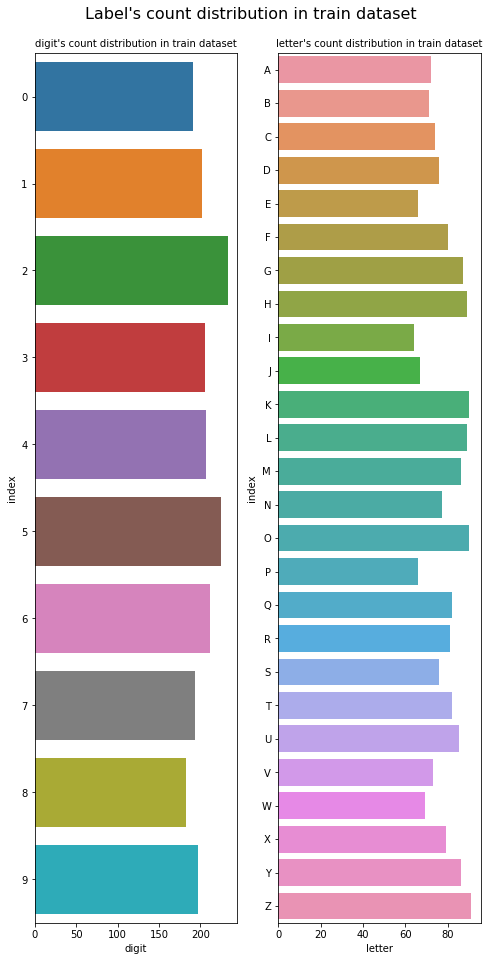

In [6]:
fig, axes = plt.subplots(figsize=[8,16],nrows=1,ncols=2)

target_cols = ["digit","letter"]

for idx, ax in enumerate(axes):

    column = target_cols[idx]
    dummy = df_train[column].value_counts().sort_index().reset_index()
    sns.barplot(data=dummy,x=column,y="index",orient='h',ax=ax,)

    ax.set_title(f"{column}'s count distribution in train dataset",fontsize=10)

plt.suptitle("Label's count distribution in train dataset",y=0.92,fontsize=16)

In [7]:
!pip install iterative-stratification

In [8]:
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

df_train_X = df_train["id"]
df_train_y = df_train[df_train.columns[1:3]]

multi_kfold = MultilabelStratifiedKFold(n_splits=5,random_state=0)

for idx,(train_idx,valid_idx) in enumerate(multi_kfold.split(df_train_X,df_train_y)):
    df_train.loc[valid_idx,"fold"] = int(idx)

In [9]:
df_train.head()

,id,digit,letter,0,1,2,3,4,5,6,...,775,776,777,778,779,780,781,782,783,fold
0,1,5,L,1,1,1,4,3,0,0,...,1,0,1,2,4,4,4,3,4,4.0
1,2,0,B,0,4,0,0,4,1,1,...,3,0,1,4,1,4,2,1,2,3.0
2,3,4,L,1,1,2,2,1,1,1,...,3,3,0,2,0,3,0,2,2,3.0
3,4,9,D,1,2,0,2,0,4,0,...,3,2,0,1,4,0,0,1,1,1.0
4,5,6,A,3,0,2,4,0,3,0,...,4,3,2,1,3,4,3,1,2,0.0


1450


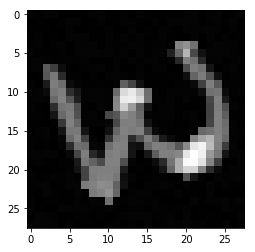

In [10]:
rand_num = np.random.randint(2048)
print(rand_num)
plt.imshow(df_train.loc[:,df_train.columns[3:-1]].iloc[rand_num].values.reshape(28,28),cmap="gray")

# 3. pytorch Dataset 생성

In [11]:
!pip install torch===1.6.0 torchvision===0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [12]:
import torch

from torch.utils.data import Dataset

In [13]:
df_train.head()

,id,digit,letter,0,1,2,3,4,5,6,...,775,776,777,778,779,780,781,782,783,fold
0,1,5,L,1,1,1,4,3,0,0,...,1,0,1,2,4,4,4,3,4,4.0
1,2,0,B,0,4,0,0,4,1,1,...,3,0,1,4,1,4,2,1,2,3.0
2,3,4,L,1,1,2,2,1,1,1,...,3,3,0,2,0,3,0,2,2,3.0
3,4,9,D,1,2,0,2,0,4,0,...,3,2,0,1,4,0,0,1,1,1.0
4,5,6,A,3,0,2,4,0,3,0,...,4,3,2,1,3,4,3,1,2,0.0


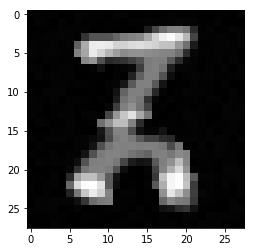

In [14]:
img_height = 28
img_width = 28

rand_num = np.random.randint(2048)
img = df_train.loc[:,df_train.columns[3:-1]].iloc[rand_num].values.reshape(img_height,img_width)
plt.imshow(img,cmap="gray")

In [59]:
class Emnst_Dataset(Dataset):
    def __init__(self, csv, img_height, img_width, transform):
        self.csv = csv.copy()
        self.ids = csv.loc[:,"id"].values
        self.digits = csv.loc[:,"digit"].values
        self.letters = csv.loc[:,"letter"].values
        self.img_height = img_height
        self.img_width = img_width
        self.transform = transform
    
    def __length__(self):
        return len(self.csv)
        
    def __getitem__(self, index):
        img_id = self.ids[index]
        img = df_train.loc[index, df_train.columns[3:-1]].values
        img = img.reshape(self.img_height, self.img_width)
        img = img.astype("uint8")
        img = img[:,:,np.newaxis]
        img = np.repeat(img,3,2)
        
        if self.transform is not None:
            img = self.transform(image=img)["image"].permute(1,2,0)
            
        digit = self.digits[index]
        letter = self.letters[index]
        
        return img, np.array([digit,letter])

In [60]:
train_dataset = Emnst_Dataset(csv=df_train,img_height=28,img_width=28, transform=train_transforms)

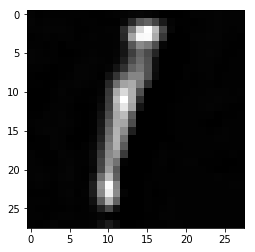

In [81]:
plt.imshow(train_dataset[0][0],cmap="gray")

In [16]:
!pip install albumentations
!pip install opencv-python

In [17]:
import albumentations as A
from albumentations.pytorch import ToTensor

train_transforms = A.Compose([
        A.Rotate(20),
        A.OneOf([
            A.IAAAdditiveGaussianNoise(),
            A.GaussNoise(),
        ], p=0.2),
        A.OneOf([
            A.MotionBlur(p=.2),
            A.MedianBlur(blur_limit=3, p=0.1),
            A.Blur(blur_limit=3, p=0.1),
        ], p=0.2),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
        A.OneOf([
            A.OpticalDistortion(p=0.3),
            A.GridDistortion(p=.1),
            A.IAAPiecewiseAffine(p=0.3),
        ], p=0.2),
        A.OneOf([
            A.CLAHE(clip_limit=2),
            A.IAASharpen(),
            A.IAAEmboss(),
            A.RandomBrightnessContrast(),            
        ], p=0.3),
        A.HueSaturationValue(p=0.3),
    #pytorch가 학습에 사용할 수 있는 형태로 Image를 출력(HWC -> CHW)
    ToTensor()
    ])

In [18]:
img = img.astype("uint8")

In [19]:
img = img[:,:,np.newaxis]
img = np.repeat(img,3,2)

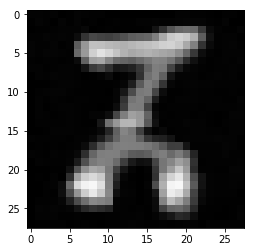

In [22]:
plt.imshow(train_transforms(image=img)["image"].permute(1,2,0),cmap="gray")